# Performamce comparison

In memory, no dask.

In [1]:
# Change dir to repo root if running from repo (rather than pip installed)
# (Assuming running from [repo]/notes/)
import os
os.chdir('../')

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple

from incremental_trees.trees import StreamingRFC

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
# Settings
MAX_ESTIMATORS = 120  # Lower to run faster

# Synthetic data

20000 samples, 2 classes, 40 features.

In [4]:
x, y = make_blobs(n_samples=20000,
                  centers=2,
                  cluster_std=100,
                  n_features=40,
                  random_state=0)

## Default params

### Standard random forest

In [5]:
def score(mod, 
          train: Tuple[np.array, np.array],
          test: Tuple[np.array, np.array],
          pr=False) -> Tuple[float, float]:
    """
    Return ROC auc on x_train and x_test (from caller) on mod. Print if requested.
    """
    y_pred_train_proba = mod.predict_proba(train[0])[:, 1]
    y_pred_test_proba = mod.predict_proba(test[0])[:, 1]

    roc_train = roc_auc_score(train[1], y_pred_train_proba)
    roc_test = roc_auc_score(test[1], y_pred_test_proba)
    if pr:
        print(f"n_ests: {len(rfc.estimators_)}")
        print(f'Train AUC: {roc_train}')
        print(f'Test AUC: {roc_test}')
        
    return roc_train, roc_test


def inc_fit(x: np.array, y: np.array,
            rfc=None,
            steps=np.arange(1, 101, 2),
            sample: int=1):
    """
    Fit a random forest model with an increasing number of estimators.
    
    Uses .fit with warm_start=True.
    
    :param rfc: RFC model to test. Default = None (use example with default RFC params).
                If model is supplied, the .n_estimators param will be ignored and managed here.
    :param steps: Range to iterate over. Sets total number of estimators that will be fit in model
                  after each iteration. Should be range with constant step size.
    :param sample: Proportion of randomly sampled training data to use on each partial_fit call.
               If sample = 1, all training data is used on each interation,
               so should behave as standard random forest. Default = 1 (100%).
    """
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.25,
                                                        random_state=1)
    
    if rfc is None:
        rfc = RandomForestClassifier(warm_start=True)
    
    train_scores = []
    test_scores = []
    for s in steps:
        # Fit model with these n ests
        rfc.set_params(n_estimators=s)
        rfc.fit(x_train, y_train)
        
        tr_score, te_score = score(rfc, 
                                   train=(x_train, y_train),
                                   test=(x_test, y_test),
                                   pr=False)
        train_scores.append(tr_score)
        test_scores.append(te_score)
    
    return train_scores, test_scores


def plot_auc(steps, train_scores, test_scores):
    """
    Plot the train and test auc scores vs total number of model estimators
    """
    
    fig = plt.figure(figsize=(4, 4))
    plt.plot(steps, train_scores)
    plt.plot(steps, test_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('auc')
    plt.legend(['train', 'test'])

CPU times: user 18.2 s, sys: 219 ms, total: 18.4 s
Wall time: 18.5 s
With 119: 1.0 | 0.6327917799469568


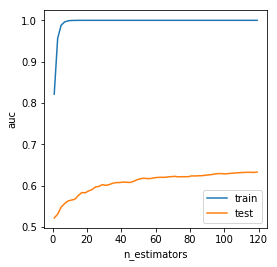

In [6]:
steps = np.arange(1, MAX_ESTIMATORS, 2)
rfc = RandomForestClassifier(warm_start=True)

%time train_scores, test_scores = inc_fit(x, y, rfc=rfc, steps=steps)
print(f"With {len(rfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

### Streaming random forest

In [7]:
def inc_partial_fit(x: np.ndarray, y:np.ndarray,
                    srfc=None,
                    steps=np.arange(1, 101, 2),
                    sample: int=0.1,
                    **kwargs) -> None:
    
    """
    Fit increasing number of estimators using .partial_fit on a subsample of the training data.
    
    StreamingRFC.n_estimators: Number of estimators that will be fit in each step. Set from first
                               difference in range (ie. range[1]-range[0])
    StreamingRFC.max_n_estimators: Limit on number of estimators than will be fit in model. Should >
                                   range[-1].
    
    :param srfc: StreamingRFC model to test. Default = None (use example with default RFC params).
                 If model is supplied, the .n_estimators param should match the constant range
                 step size.
    :param steps: Range to iterate over. Sets total number of estimators that will be fit in model
                  after each iteration. Should be range with constant step size.
    :param sample: Proportion of randomly sampled training data to use on each partial_fit call.
                   If sample = 1, all training data is used on each interation,
                   so should behave as standard random forest. Default = 0.1 (10%)
    """
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.25,
                                                        random_state=1)
    n_train = x_train.shape[0]
    
    if srfc is None:
        srfc = StreamingRFC(n_estimators_per_chunk=np.diff(steps)[0],
                            max_n_estimators=np.max(steps),
                            **kwargs)
    
    train_scores = []
    test_scores = []
    for s in steps:
        
        use_idx = np.arange(0, n_train)[np.random.randint(low=0, 
                                                    high=n_train, 
                                                    size=int(n_train * sample))]
        
        # Fit model with these n ests
        srfc.partial_fit(x_train[use_idx, :], y_train[use_idx],
                         classes=np.unique(y))
        
        tr_score, te_score = score(srfc,
                                   train=(x_train, y_train),
                                   test=(x_test, y_test),
                                   pr=False)
        train_scores.append(tr_score)
        test_scores.append(te_score)
    
    return train_scores, test_scores

#### As normal random forest
1 estimator per full subset

CPU times: user 32.2 s, sys: 78.1 ms, total: 32.3 s
Wall time: 32.7 s
With 119: 0.9999999999999999 | 0.6331369808306709


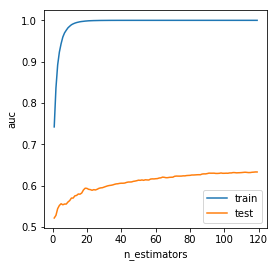

In [8]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators=1,
                    max_n_estimators=np.max(steps))

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Partial random forest
1 estimator per 10 % subset

CPU times: user 20.1 s, sys: 15.6 ms, total: 20.1 s
Wall time: 20.5 s
With 119: 0.8225306784087263 | 0.6294571314102564


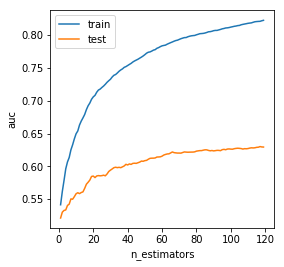

In [9]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators_per_chunk=1,
                    max_n_estimators=np.max(steps))

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Partial random forest
3 estimators per 10 % subset, but /3 fewer steps

CPU times: user 7.44 s, sys: 31.2 ms, total: 7.47 s
Wall time: 7.56 s
With 120: 0.8246353545629453 | 0.6307688947683706


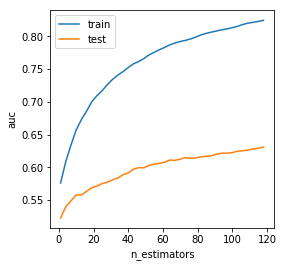

In [10]:
steps = np.arange(1, MAX_ESTIMATORS, 3)
srfc = StreamingRFC(n_estimators_per_chunk=3,
                    max_n_estimators=np.max(steps))

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Forest of partial decision trees
1 estimator per 10 % subset with all features

CPU times: user 22.3 s, sys: 31.2 ms, total: 22.3 s
Wall time: 22.6 s
With 119: 0.8138937870631217 | 0.6356310672155322


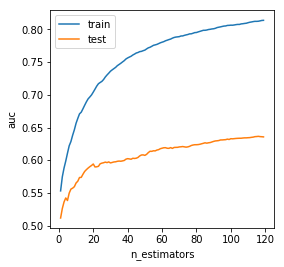

In [11]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators_per_chunk=1,
                    max_n_estimators=np.max(steps),
                    max_features=x.shape[1])

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

# Optimised parameters

Using a better set of parameters for this dataset

In [12]:
from sklearn.model_selection import RandomizedSearchCV as RCV

grid = RCV(RandomForestClassifier(n_estimators=30, 
                                  n_jobs=-1),
           param_distributions={'min_samples_leaf': [1, 2, 10, 30, 60, 120, 240, 480],
                                'min_samples_split': [2, 10, 30, 60, 120, 240, 480],
                                'min_impurity_decrease': [0, 0.05, 0.1, 0.2, 0.3]},
           cv=3,
           n_iter=100,
           verbose=10,
           n_jobs=-1)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25,
                                                    random_state=1)

grid.fit(x_train, y_train)
print(grid.best_estimator_.get_params(deep=True))

tr_score, te_score = score(grid,
                           train=(x_train, y_train),
                           test=(x_test, y_test),
                           pr=True)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_impurity_split': None, 'min_samples_leaf': 60, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
n_ests: 119
Train AUC: 0.8107342572755221
Test AUC: 0.6393736367965102


In [13]:
params = grid.best_estimator_.get_params()
params.pop('warm_start', None)
params.pop('n_jobs', None)
params.pop('n_estimators', None)
params

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_impurity_split': None,
 'min_samples_leaf': 60,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'oob_score': False,
 'random_state': None,
 'verbose': 0}

### Standard random forest

CPU times: user 5.44 s, sys: 46.9 ms, total: 5.48 s
Wall time: 5.55 s
With 111: 0.8330460502886542 | 0.649373182395347


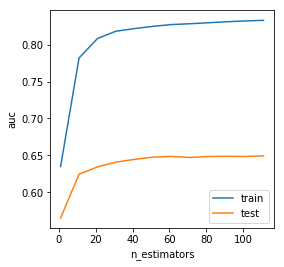

In [14]:
steps = np.arange(1, MAX_ESTIMATORS, 10)

rfc = RandomForestClassifier(warm_start=True,
                             **params)

%time train_scores, test_scores = inc_fit(x, y, rfc=rfc, steps=steps)
print(f"With {len(rfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### As normal random forest
1 estimator per full subset

CPU times: user 24.4 s, sys: 0 ns, total: 24.4 s
Wall time: 24.6 s
With 119: 0.82665000402489 | 0.6500849442174572


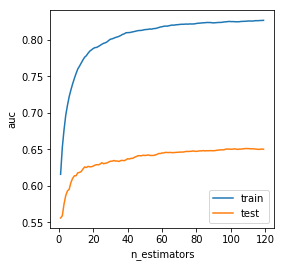

In [15]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators_per_chunk=1,
                    max_n_estimators=np.max(steps),
                    **params)

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Partial random forest
1 estimator per 10 % subset

CPU times: user 16.4 s, sys: 15.6 ms, total: 16.4 s
Wall time: 16.7 s
With 119: 0.6795318199557177 | 0.6549408766486443


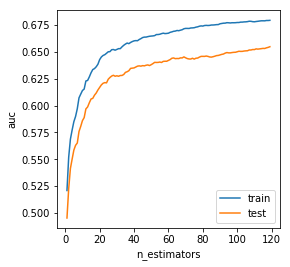

In [16]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators=1,
                    max_n_estimators=np.max(steps),
                    **params)

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Partial random forest
3 estimators per 10 % subset, but /3 fewer steps

CPU times: user 2.19 s, sys: 0 ns, total: 2.19 s
Wall time: 2.2 s
With 40: 0.6577470048702592 | 0.6314094564082084


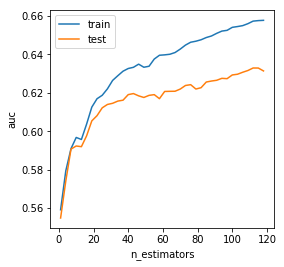

In [17]:
steps = np.arange(1, MAX_ESTIMATORS, 3)
srfc = StreamingRFC(n_estimators=3,
                    max_n_estimators=np.max(steps),
                    **params)

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

#### Forest of partial decision trees
1 estimator per 10 % subset with all features

In [18]:
params.pop('max_features', None)

'auto'

CPU times: user 18.7 s, sys: 46.9 ms, total: 18.8 s
Wall time: 19.1 s
With 119: 0.6836834655810746 | 0.6486341405033996


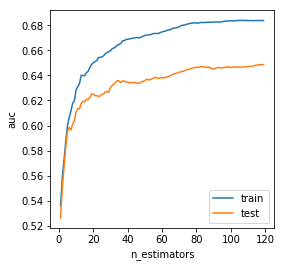

In [19]:
steps = np.arange(1, MAX_ESTIMATORS, 1)
srfc = StreamingRFC(n_estimators=1,
                    max_n_estimators=np.max(steps),
                    max_features=x.shape[1],
                    **params)

%time train_scores, test_scores = inc_partial_fit(x, y, srfc=srfc, steps=steps, sample=0.1)
print(f"With {len(srfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)